### Import necessary libraries

In [2]:

from bs4 import BeautifulSoup
import requests
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import nltk
import re

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

/Users/rsahani/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# Function to scrape IMDb movie reviews
def scrape_imdb_reviews(movie_url):
    response = requests.get(movie_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Extracting review text and sentiment labels (positive/negative)
    reviews = []
    for review_div in soup.find_all('div', class_='text show-more__control'):
        review_text = review_div.get_text(strip=True)
        reviews.append({'text': review_text, 'sentiment': 'positive'})
    
    for review_div in soup.find_all('div', class_='text show-more__control_expanded'):
        review_text = review_div.get_text(strip=True)
        reviews.append({'text': review_text, 'sentiment': 'negative'})
    print(reviews)
    return reviews

In [4]:
# IMDb movie URL (replace with the actual movie URL)
movie_url = 'https://www.imdb.com/title/tt12915716/reviews'

# Scrape IMDb movie reviews
movie_reviews = scrape_imdb_reviews(movie_url)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(movie_reviews)

[{'text': "Besides a soulful score by Ajay Atul, this adaptation of Ramayana is a baffling and collosal dissapointment.My Rating : 15/100Adipurush is a disgusting mockery of a beloved and celebrated chapter of Indian Mythology. Baring the intimidating Sharad Kelkar's voice and Ajay Atul's profound score, nothing really clicks in this modern adaptation. Om Raut's precarious attempt is a monumental disaster in every aspects of filmaking. Starting from the caricaturish character design of Raavan, cartoonish rendering of the banar sena , cringe dialogues & hurried screenplay everything forces us to bash this misfire. Some salvageable performanaces by Kriti Sanon and Devdatta Nage isnt quite enough to save this project. A mere cash-grabbing project with no acknowledgement of the source material , relying only to play with the Indian sentiments is the prime idea behind this.A proper case of poor casting, whoever decided to cast the stone faced Prabhas to portray the vibrant character of Ram 

### Data Preprocessing


In [5]:
# nltk.download('wordnet')

In [6]:

# Function for cleaning text
def clean_text(text):
    cleaned_text = text.lower()  # Convert to lowercase for consistency
    cleaned_text = re.sub(r"[^\w\s]", "", cleaned_text)  # Remove special characters

    return cleaned_text


# Function for tokenization
def tokenize_text(text):
    tokens = nltk.word_tokenize(text)

    return tokens


# Function for removing stopwords
def remove_stopwords(tokens):

    stop_words = set(stopwords.words("english"))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

    return filtered_tokens


# Function for lemmatization
def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

# Text Cleaning
df["text_cleaned"] = df["text"].apply(lambda x: clean_text(x))

# Tokenization
df["tokens"] = df["text_cleaned"].apply(lambda x: tokenize_text(x))

# Stopword Removal
df["tokens"] = df["tokens"].apply(lambda x: remove_stopwords(x))

# Lemmatization
df["tokens"] = df["tokens"].apply(lambda x: lemmatize_text(x))

In [7]:
# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['sentiment'], test_size=0.2, random_state=42
)

In [8]:
# Feature Extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_train = tfidf_vectorizer.fit_transform(train_data)
tfidf_test = tfidf_vectorizer.transform(test_data)

# Model Training using Naive Bayes
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(tfidf_train, train_labels)

MultinomialNB()

In [9]:
# Model Evaluation
predictions = naive_bayes_classifier.predict(tfidf_test)

# Evaluate accuracy
accuracy = accuracy_score(test_labels, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report
print('\nClassification Report:')
print(classification_report(test_labels, predictions))

Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

    positive       1.00      1.00      1.00         5

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



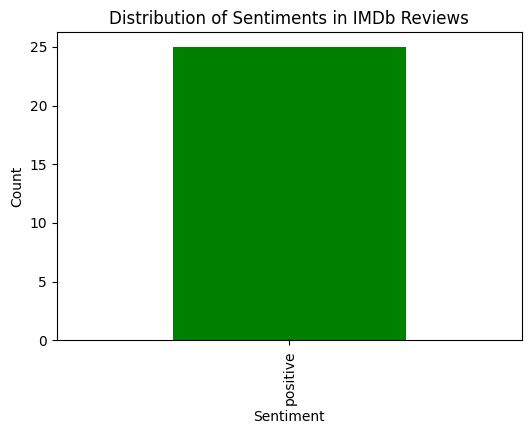

In [10]:
# Visualize the distribution of sentiment predictions
plt.figure(figsize=(6, 4))
df['sentiment'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Sentiments in IMDb Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()